In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy.interpolate import interp1d
import glob

from gwtess import Gwtess, Gwtess_galaxy
%matplotlib inline

In [2]:
tesspath = '../data/tess-bandpass.csv'
spectrapath = glob.glob('../data/spectrum-at-*.csv')

# spectrapath = glob.glob('../data/redknova-at-*.csv')

galaxypath = '../data/spectrum-of-ngc4339.csv'

In [3]:
spectime = [0.49, 0.53, 1.46, 2.49, 3.46, 4.51, 7.45, 8.46]

nominalmerger = 1540
highmerger = 1540+3200
lowmerger = 1540-1220

Chruslinska2017rate = 48
Fong2015rate = 240-180

integration=6

GWT = Gwtess_galaxy(tesspath, spectrapath, spectime, mergerrate=nominalmerger, integration=integration)
eventAbsMag = GWT.get_obs_absmag()

# apmags, detected = GWT.sim_events(years=100)

# apmags_var, detected_var, is_onaxis = GWT.sim_events(fixedlum=False, years=100)
apmags_var, detected_var, is_onaxis = GWT.sim_events(fixedlum=False, years=100)

/Users/tom/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


(array([   2.,   16.,   71.,  197.,  992.]),
 array([13, 14, 15, 16, 17, 18]),
 <a list of 5 Patch objects>)

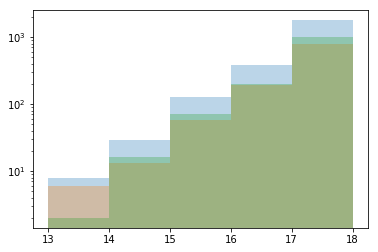

In [4]:
apmags_detected = apmags_var[detected_var]
is_onaxis_detected = is_onaxis[detected_var]

plt.hist(apmags_detected, alpha=0.30, bins=np.arange(13,19,1), log=True)
plt.hist(apmags_detected[~is_onaxis_detected], alpha=0.30, bins=np.arange(13,19,1), log=True)
plt.hist(apmags_detected[is_onaxis_detected], alpha=0.30, bins=np.arange(13,19,1), log=True)


In [5]:
print('total detections for variable brightness = {:.2f}'.format(
    apmags_detected.shape[0] * 0.041 / 1))
print('total on-axis detections for variable brightness = {:.2f}'.format(
    apmags_detected[is_onaxis_detected].shape[0] * 0.041 / 1))
print('total off-axis detections for variable brightness = {:.2f}'.format(
    apmags_detected[~is_onaxis_detected].shape[0] * 0.041 / 1))
# print('total detections for fixed brightness = {:.2f}'.format(
#     apmags_detected.shape[0] * 0.041 / 1))

print()
print('total detections for variable brightness = {:.2f}'.format(
    apmags_detected.shape[0]  / 1))
print('total on-axis detections for variable brightness = {:.2f}'.format(
    apmags_detected[is_onaxis_detected].shape[0]  / 1))
print('total off-axis detections for variable brightness = {:.2f}'.format(
    apmags_detected[~is_onaxis_detected].shape[0]  / 1))

total detections for variable brightness = 174.82
total on-axis detections for variable brightness = 97.29
total off-axis detections for variable brightness = 77.53

total detections for variable brightness = 4264.00
total on-axis detections for variable brightness = 2373.00
total off-axis detections for variable brightness = 1891.00


In [6]:
noff = GWT.distances[detected_var & ~is_onaxis].shape[0]
non = GWT.distances[detected_var & is_onaxis].shape[0]

a1 = np.sort(GWT.distances[detected_var & ~is_onaxis] / 1.E6)[int(np.round(noff*0.05, ))]
a2 = np.sort(GWT.distances[detected_var & ~is_onaxis] / 1.E6)[int(np.round(noff*0.95, ))]
print('off-axis distance range: {:.2f} - {:.2f}'.format(a1,a2))
       
a1 = np.sort(GWT.distances[detected_var & is_onaxis] / 1.E6)[int(np.round(non*0.05, ))]
a2 = np.sort(GWT.distances[detected_var & is_onaxis] / 1.E6)[int(np.round(non*0.95, ))]
print('on-axis distance range: {:.2f} - {:.2f}'.format(a1,a2))


print('{:.2f}% are with 200Mpc'.format(
    GWT.distances[detected_var & (GWT.distances < 200E6)].shape[0] /
      GWT.distances[detected_var].shape[0] * 100))

off-axis distance range: 56.07 - 230.24
on-axis distance range: 169.15 - 724.63
41.04% are with 200Mpc


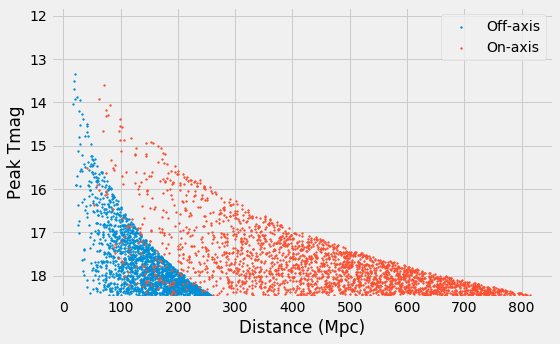

In [7]:
with plt.style.context(('fivethirtyeight')):
    fig = plt.figure(figsize=[8,5])
    plt.scatter(GWT.distances[detected_var & ~is_onaxis] / 1.E6, 
                apmags_var[detected_var & ~is_onaxis], label='Off-axis', s=3)
    plt.scatter(GWT.distances[detected_var & is_onaxis] / 1.E6, 
                apmags_var[detected_var & is_onaxis], label='On-axis', s=3)
    plt.ylim(18.5,11.8)
#     plt.xlim(0,3.5)
    plt.ylabel('Peak Tmag')
    plt.xlabel('Distance (Mpc)')
    plt.legend()
    fig.tight_layout()
#     fig.savefig('events-per-centuary.png')

In [8]:
print('observed mags:\n {:.2f}\n {:.2f}\n {:.2f}\n {:.2f}\n {:.2f}\n {:.2f}\n {:.2f}\n {:.2f}\n'.format(
    *GWT.get_apmag(eventAbsMag, 41E6)))

observed mags:
 17.33
 17.31
 17.57
 18.08
 18.46
 18.95
 20.27
 20.69



In [12]:
# we are only sensitive to ~60% of detections 
# 30% at 170 Mpc
# 30% at 190 Mpc
n = GWT.distances[detected_var].shape[0]
rand = np.random.sample(size=n)
observed = rand <= 0.6
dd = GWT.distances[detected_var] / 1.E6
ddearly = dd[observed & (rand <= 0.3)]
ddlate = dd[observed & (rand > 0.3)]

print('total EM+GW detection in 100 years = {}'.format(ddearly[ddearly < 170].shape[0] +
                                                       ddlate[ddlate < 190].shape[0]))
print('total EM+GW detection in 100 years in TESS fov = {}'.format(0.041*(ddearly[ddearly < 170].shape[0] +
                                                       ddlate[ddlate < 190].shape[0])))
print('total EM+GW detection in 2 years in TESS fov = {}'.format(0.041*(ddearly[ddearly < 170].shape[0] +
                                                       ddlate[ddlate < 190].shape[0]) / 50))
print()
print('total EM+GW detection in 2 years in TESS on-axis fov = {}'.format(0.041*(
    dd[observed & (rand <= 0.3) & is_onaxis_detected & (dd < 170)].shape[0] + 
    dd[observed & (rand > 0.3) & is_onaxis_detected & (dd < 190)].shape[0])) )
print('total EM+GW detection in 2 years in TESS off-axis fov = {}'.format(0.041*(
    dd[observed & (rand <= 0.3) & ~is_onaxis_detected & (dd < 170)].shape[0] + 
    dd[observed & (rand > 0.3) & ~is_onaxis_detected & (dd < 190)].shape[0])) )
print()
print('total EM+GW detection in 2 years in TESS on-axis fov = {}'.format(0.041*(
    dd[~observed & (rand <= 0.3) & is_onaxis_detected & (dd < 170)].shape[0] + 
    dd[~observed & (rand > 0.3) & is_onaxis_detected & (dd < 190)].shape[0])) )
print('total EM+GW detection in 2 years in TESS off-axis fov = {}'.format(0.041*(
    dd[~observed & (rand <= 0.3) & ~is_onaxis_detected & (dd < 170)].shape[0] + 
    dd[~observed & (rand > 0.3) & ~is_onaxis_detected & (dd < 190)].shape[0])) )
print()
print('total EM+GW detection in 2 years in TESS on-axis fov = {}'.format(0.041*(
    dd[~observed & (rand <= 0.3) & is_onaxis_detected & (dd >= 170)].shape[0] + 
    dd[~observed & (rand > 0.3) & is_onaxis_detected & (dd >= 190)].shape[0])) )
print('total EM+GW detection in 2 years in TESS off-axis fov = {}'.format(0.041*(
    dd[~observed & (rand <= 0.3) & ~is_onaxis_detected & (dd >= 170)].shape[0] + 
    dd[~observed & (rand > 0.3) & ~is_onaxis_detected & (dd >= 190)].shape[0])) )
print()
print('total EM+GW detection in 2 years in TESS on-axis fov = {}'.format(0.041*(
    dd[observed & (rand <= 0.3) & is_onaxis_detected & (dd >= 170)].shape[0] + 
    dd[observed & (rand > 0.3) & is_onaxis_detected & (dd >= 190)].shape[0])) )
print('total EM+GW detection in 2 years in TESS off-axis fov = {}'.format(0.041*(
    dd[observed & (rand <= 0.3) & ~is_onaxis_detected & (dd >= 170)].shape[0] + 
    dd[observed & (rand > 0.3) & ~is_onaxis_detected & (dd >= 190)].shape[0])) )
print()
print('total EM+GW detection in 2 years in TESS on-axis fov = {}'.format(0.041*(
    dd[observed & (rand <= 0.3) & is_onaxis_detected & (dd >= 170)].shape[0] + 
    dd[observed & (rand > 0.3) & is_onaxis_detected & (dd >= 190)].shape[0])) )
print('total EM+GW detection in 2 years in TESS off-axis fov = {}'.format(0.041*(
    dd[observed & (rand <= 0.3) & ~is_onaxis_detected & (dd >= 170)].shape[0] + 
    dd[observed & (rand > 0.3) & ~is_onaxis_detected & (dd >= 190)].shape[0])) )

# print('total on-axis detections for variable brightness = {:.2f}'.format(
#     apmags_detected[is_onaxis_detected].shape[0] * 0.041 / 1))
# print('total off-axis detections for variable brightness = {:.2f}'.format(
#     apmags_detected[~is_onaxis_detected].shape[0] * 0.041 / 1))


# 786 * 0.041

total EM+GW detection in 100 years = 896
total EM+GW detection in 100 years in TESS fov = 36.736000000000004
total EM+GW detection in 2 years in TESS fov = 0.73472

total EM+GW detection in 2 years in TESS on-axis fov = 3.2800000000000002
total EM+GW detection in 2 years in TESS off-axis fov = 33.456

total EM+GW detection in 2 years in TESS on-axis fov = 2.87
total EM+GW detection in 2 years in TESS off-axis fov = 24.067

total EM+GW detection in 2 years in TESS on-axis fov = 36.039
total EM+GW detection in 2 years in TESS off-axis fov = 6.519

total EM+GW detection in 2 years in TESS on-axis fov = 55.104
total EM+GW detection in 2 years in TESS off-axis fov = 13.489

total EM+GW detection in 2 years in TESS on-axis fov = 55.104
total EM+GW detection in 2 years in TESS off-axis fov = 13.489


In [18]:
x = (1.514E6 * 70 * 3600)
y = x * 10**(-0.4*11.3)
z = np.sqrt(y) / (x * 10**(-0.4*17.3)) / np.sqrt(0.5)

t_sim = np.arange(0,10,1./48)
m_sim = GWT.get_apmag(GWT._f5(t_sim), GWT.obs_distance)

yerr_sim2 = np.sqrt(GWT.get_yerr_mag(m_sim, 11.3) ** 2 + z**2)
erroradd2 = np.random.normal(scale=yerr_sim2[np.isfinite(yerr_sim2)], size=len(m_sim[np.isfinite(yerr_sim2)]))

yerr_sim = GWT.get_yerr_mag(m_sim, 11.3)
erroradd = np.random.normal(scale=yerr_sim[np.isfinite(yerr_sim)], size=len(m_sim[np.isfinite(yerr_sim)]))

/Users/tom/gitcode/messing-with-gw/code/gwtess.py:255: RuntimeWarning: invalid value encountered in log10
  yerr = np.log10(1.0 - (noise)) / -0.4


In [19]:
# import pdb
# pdb.pm()

In [20]:
1.  / ((GWT.TESS_noise_1h(18.12) / 1.E6 / np.sqrt(0.5)) **2 + z**2)**0.5


5.035350376342536

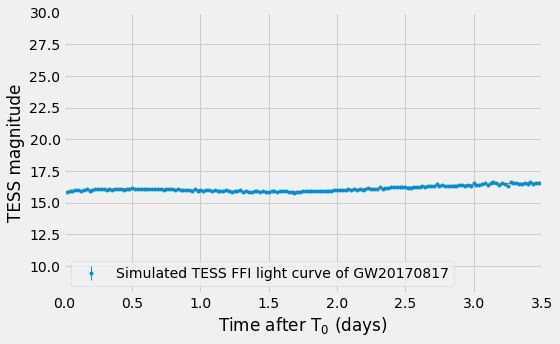

In [22]:


with plt.style.context(('fivethirtyeight')):
    fig = plt.figure(figsize=[8,5])


    plt.errorbar(t_sim[np.isfinite(yerr_sim)],m_sim[np.isfinite(yerr_sim)]+erroradd, 
             yerr=yerr_sim[np.isfinite(yerr_sim)], fmt='.', lw=1,
                 label = 'Simulated TESS FFI light curve of GW20170817')
#     plt.errorbar(t_sim[np.isfinite(yerr_sim2)],m_sim[np.isfinite(yerr_sim2)]+erroradd2, 
#              yerr=yerr_sim2[np.isfinite(yerr_sim2)], fmt='.', lw=1,
#                  label = 'Simulated TESS FFI light curve of GW20170817')
    plt.plot(t_sim[np.isfinite(yerr_sim)], m_sim[np.isfinite(yerr_sim)], lw=1)
#     plt.ylim(19.9,16.9)
    plt.xlim(0,3.5)
    plt.xlabel('Time after T$_0$ (days)')
    plt.ylabel('TESS magnitude')
    plt.legend(loc=3)
    fig.tight_layout()
#     fig.savefig('tess-lc-gw20170817-v3.png')

In [30]:
# plt.plot(t_sim[np.isfinite(yerr_sim)], m_sim[np.isfinite(yerr_sim)], lw=1)
# plt.xlim(3.35,3.5)
# plt.ylim(18.3,18.5)



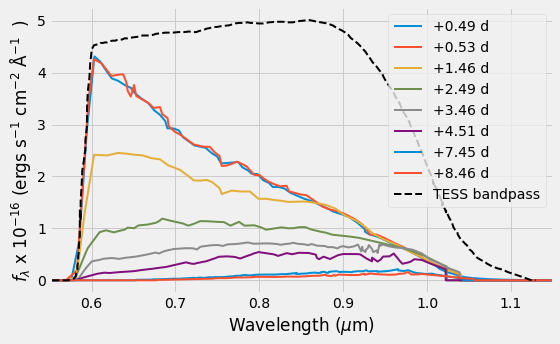

In [79]:
t = [0.49, 0.53, 1.46, 2.49, 3.46, 4.51, 7.45, 8.46]
with plt.style.context(('fivethirtyeight')):
    fig = plt.figure(figsize=[8,5])

    for i, s in enumerate(GWT.spectra_l):
        plt.plot(GWT.wavelength_ang/10000, s/1E-16,
                     label ='+{} d'.format(t[i] ), lw=2)
#     plt.ylim(19.9,16.9)
    plt.xlim(0.5500,1.1500)
    plt.xlabel('Wavelength ($\mu$m)')
    plt.ylabel('$f_\lambda$ x $10^{-16}$ (ergs s$^{-1}$ cm$^{-2}$ Å$^{-1}$  )')
    plt.plot(GWT.tess_ang/10000, GWT.tess_qe*5, color='k', ls='--', lw=2, label='TESS bandpass')
    plt.legend(loc=0)
    fig.tight_layout()
    fig.savefig('tess-convolved-spectra-gw20170817.png')
#


/Users/tom/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log10
  if sys.path[0] == '':


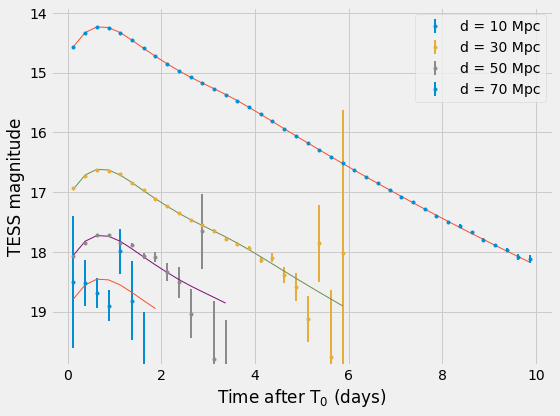

In [59]:

t_sim = np.arange(1./8,10,1./4)

with plt.style.context(('fivethirtyeight')):
    fig = plt.figure(figsize=[8,6])
    
    for d in [10E6, 30E6,  50E6, 70E6]:
        mag1 = GWT.get_apmag(eventAbsMag, d)
        f5 = interp1d(GWT.time, mag1, kind='cubic',
                          bounds_error=False, fill_value='extrapolate')
        m_sim = f5(t_sim)
        yerr_sim =  np.log10((1.0 - (GWT.TESS_noise_1h(m_sim)/1.E6 / np.sqrt(6)))) / -0.4
        erroradd = np.random.normal(scale=yerr_sim[np.isfinite(yerr_sim)], size=len(m_sim[np.isfinite(yerr_sim)]))
        plt.errorbar(t_sim[np.isfinite(yerr_sim)],m_sim[np.isfinite(yerr_sim)]+erroradd, 
                 yerr=yerr_sim[np.isfinite(yerr_sim)], fmt='.', lw=2,
                     label = 'd = {0:.0f} Mpc'.format(d/1E6))
        plt.plot(t_sim[np.isfinite(yerr_sim)], m_sim[np.isfinite(yerr_sim)], lw=1)
    plt.ylim(19.9,13.9)
#     plt.xlim(0,3.5)
    plt.xlabel('Time after T$_0$ (days)')
    plt.ylabel('TESS magnitude')
    plt.legend(loc=0)
    fig.tight_layout()
#     fig.savefig('tess-lc-various-distances.png')


In [60]:
plt.plot(GWT._f6(np.arange(4000,12000)))

AttributeError: 'Gwtess_galaxy' object has no attribute '_f6'

In [40]:
a = 6.59*900 * 10**(-0.4 * 11.3)
b = 6.59*900 * 10**(-0.4 * 17.3)
np.sqrt(a) / b

593.52092918692517

In [41]:
-2.5* np.log10(251)

-5.9991843037025951

In [42]:
GWT.TESS_noise_1h(11.3) /10**4

0.037690622481264341

In [43]:
# n = 4.403E11
x = 4.403E11 * 10**(-0.4 * 8) 
print(np.sqrt(x)/x)

5.99964642849e-05


In [44]:
b = 18.3
np.sqrt(np.sqrt(4.403E11 * 10**(-0.4 * (b+6)) ) / (4.403E11 * 10**(-0.4 * b) ) )

0.020847924646192954

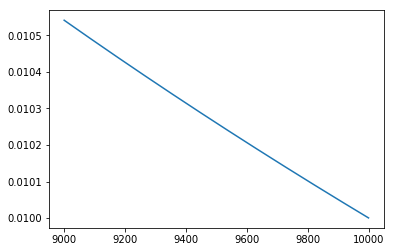

In [45]:
n = np.arange(9000,10000,1)
plt.plot(n, np.sqrt(n)/n)

In [46]:
x = (1.514E6 * 70 * 3600)
y = x * 10**(-0.4*11.3)
np.sqrt(y) / (x * 10**(-0.4*17.3))

0.074000864280179143

In [47]:
GWT.get_absmag(11.3, GWT.obs_distance)

-21.763919283598678

In [48]:
np.where(np.random.normal(size=100)<1, )

(array([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16, 17, 19,
        20, 21, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
        39, 40, 41, 45, 47, 48, 50, 52, 53, 54, 55, 56, 57, 59, 60, 61, 63,
        64, 65, 66, 67, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82,
        83, 84, 85, 86, 87, 88, 89, 90, 93, 94, 95, 97, 98, 99]),)

In [49]:
np.nonzero(is_onaxis == True)[0].shape[0] / is_onaxis.shape[0]

0.03866818181818182

In [50]:
is_onaxis[detected_var][is_onaxis[detected_var] == False].shape

(1919,)

In [36]:
apmags_var[detected_var].max()

18.452769779018251